In [11]:
### 1. Non LLM based workflows - Solve a maths problem
### 2. LLM based workflows - Solve a customer support problem

In [12]:
## Quadratic Equation workflow ---

from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal

In [13]:
class QuadState(TypedDict):
    a: int
    b: int
    c: int

    equation: str
    discriminant: float
    result: str

In [14]:
def show_equation(state: QuadState):
    if state['b'] < 0 and state['c'] < 0:
        equation = f"{state['a']}x^2 {state['b']}x {state['c']}"
    elif state['b'] > 0 and state['c'] > 0:
        equation = f"{state['a']}x^2 +{state['b']}x +{state['c']}"
    elif state['b'] < 0 and state['c'] > 0:
        equation = f"{state['a']}x^2 {state['b']}x +{state['c']}"
    elif state['b'] > 0 and state['c'] < 0:
        equation = f"{state['a']}x^2 +{state['b']}x {state['c']}"
    return {"equation": equation}

def calculate_discriminant(state: QuadState):
    discriminant = state["b"]**2 - (4*state["a"]*state["c"])
    return {"discriminant": discriminant}

def real_roots(state: QuadState):
    a, b, c = state['a'], state['b'], state['c']
    root1 = (-b + state['discriminant']**0.5) / (2*a)
    root2 = (-b - state['discriminant']**0.5) / (2*a)
    result = f"The roots are real and distinct: {root1} and {root2}"
    return {"result": result}

def repeated_roots(state: QuadState):
    a, b, c = state['a'], state['b'], state['c']
    roots = (-b) / (2*a)
    result = f"The roots are real and repeated: {roots}"
    return {"result": result}

def complex_roots(state: QuadState):
    result = f"The roots are complex and cannot be calculated using real numbers."
    return {"result": result}

def check_conditions(state: QuadState) -> Literal["real_roots", "repeated_roots", "complex_roots"]: #real_roots, repeated_roots, complex_roots are the functions name
    if state['discriminant'] > 0:
        return "real_roots" ## These are the node names that we will use in the graph to connect the nodes
    elif state['discriminant'] == 0:
        return "repeated_roots"
    else:
        return "complex_roots"

In [15]:
graph = StateGraph(QuadState)

graph.add_node("show_equation", show_equation)
graph.add_node("calculate_discriminant", calculate_discriminant)
graph.add_node("real_roots", real_roots)
graph.add_node("repeated_roots", repeated_roots)
graph.add_node("complex_roots", complex_roots)

graph.add_edge(START, 'show_equation')
graph.add_edge("show_equation", "calculate_discriminant")
graph.add_conditional_edges("calculate_discriminant", check_conditions)
graph.add_edge("real_roots", END)
graph.add_edge("repeated_roots", END)
graph.add_edge("complex_roots", END)

workflow = graph.compile()


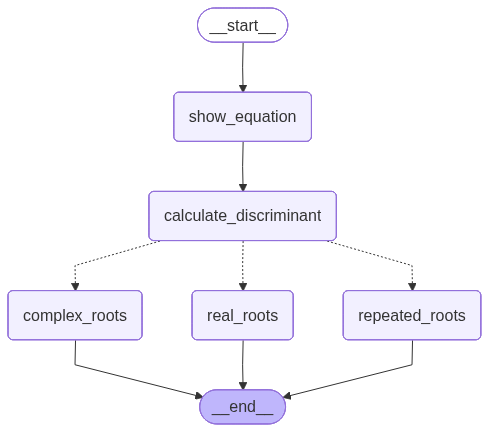

In [17]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [20]:
initial_state = {
    "a":4, "b":8, "c":4
}
final_state = workflow.invoke(initial_state)  

final_state


{'a': 4,
 'b': 8,
 'c': 4,
 'equation': '4x^2 +8x +4',
 'discriminant': 0,
 'result': 'The roots are real and repeated: -1.0'}

In [ ]:
######## LLM based conditional workflows - Review handling workflow

##review -----> sentiment analysis ----> if sentiment is negative -> run_diagnosis(analyze more using LLM like urgency, tone, issue type) -----> escalate to human agent
#                                  ----> if sentiment is positive -> send thank you message 

In [35]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from dotenv import load_dotenv
import os
from pydantic import BaseModel, Field
from euriai.langchain import create_chat_model
load_dotenv()
api_key = os.getenv("key") 

In [36]:
chat_model = create_chat_model(
    api_key=api_key,
    model="gpt-4.1-nano",
    temperature=0.7
)

In [37]:
class SentimentReview(BaseModel):
    review_score: float = Field(description="Sentiment score of the review, ranging from 1 to 5 where 1 is the lowest review and 5 is the highest", ge=1, le=5)
    sentiment: Literal["positive", "negative"] = Field(description="Overall sentiment of the review")

structured_model = chat_model.with_structured_output(SentimentReview) 

review = "The product quality is terrible and the delivery was delayed. I'm very disappointed."
prompt = f"Evaluate the sentiment of the following review and provide a score out of 1 to 10 and a sentiment (positive or negative):\n\nReview: {review}"

output = structured_model.invoke(prompt)
print(output.review_score)
print(output.sentiment)

1.0
negative


In [43]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["delivery", "product_quality", "customer_service"] = Field(description="Type of issue identified in the review")
    tone: Literal["angry", "frustrated", "neutral", "happy"] = Field(description="Tone of the review")
    urgency: Literal["low", "medium", "high"] = Field(description="Urgency of the issue")

structured_model1 = chat_model.with_structured_output(DiagnosisSchema) 

In [39]:
class ReviewState(TypedDict):
    review: str
    review_score: float
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [44]:
def find_Sentiment(state: ReviewState):
    prompt = f"Evaluate the sentiment of the following review and provide a score out of 1 to 10 and a sentiment (positive or negative):\n\nReview: {state['review']}"
    output = structured_model.invoke(prompt)
    return {"review_score": output.review_score, "sentiment": output.sentiment}  

def positive_response(state: ReviewState):
    response = "Thank you for your positive review! We're glad you had a good experience."
    return {"response": response}

def run_diagnosis(state: ReviewState):
    prompt = f"Analyze the following negative review and provide insights on the urgency, tone, and issue type:\n\nReview: {state['review']}"
    output = structured_model1.invoke(prompt)
    return {"diagnosis": output.model_dump()}

def negative_response(state: ReviewState):
    response = "We're sorry to hear about your experience. We'll work on improving our service."
    return {"response": response}

def check_conditions(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:
    if state['sentiment'] == "negative":
        return "run_diagnosis"
    else:
        return "positive_response"

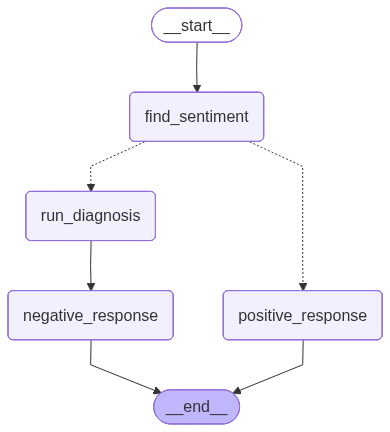

In [45]:
graph = StateGraph(ReviewState)

graph.add_node("find_sentiment", find_Sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)


graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", check_conditions)
graph.add_edge("positive_response", END)
graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)

workflow = graph.compile()

from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())


In [46]:
initial_state = {
    "review": "The product quality is terrible and the delivery was delayed. I'm very disappointed."
}

workflow.invoke(initial_state)

{'review': "The product quality is terrible and the delivery was delayed. I'm very disappointed.",
 'review_score': 1.0,
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'product_quality',
  'tone': 'frustrated',
  'urgency': 'high'},
 'response': "We're sorry to hear about your experience. We'll work on improving our service."}